Welcome to the last notebook, where we run our final choice of model on the testing set and evaluate its performance!

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../Data/default.csv", skiprows=1, index_col = "ID")

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
df_train, df_test = train_test_split(df.copy(),
                                        shuffle = True,
                                        random_state = 167,
                                        test_size = .2,
                                        stratify = df["default payment next month"])

The next two blocks give the metrics and plots that will describe our model's performance.

In [16]:
from sklearn.metrics import confusion_matrix

#returns in order: (0,0), (0,1), (1,0), (1,1)
def conf_matrix_components(cutoffs, true_data, predicted_prob):
    tp_s=[]
    fp_s=[]
    tn_s=[]
    fn_s=[]
    
    for cutoff in cutoffs:
        pred_cutoff=1*(predicted_prob >=cutoff)
        cmat=confusion_matrix(true_data, pred_cutoff)
        tn = cmat[0][0]
        tp = cmat[1][1]
        fp = cmat[0][1]
        fn = cmat[1][0]
        
        tp_s.append(tp)
        tn_s.append(tn)
        fp_s.append(fp)
        fn_s.append(fn)
        
    return [tn_s, fp_s, fn_s, tp_s]

#precision scores given list of confusion matrix components in order left-to-right and up-to-down
#similarly for the other scores
def prec_scores(list_comps): 
    fp_s=list_comps[1]
    tp_s=list_comps[3]
    prec=np.zeros(len(fp_s))
    for i in range(len(tp_s)):
        if tp_s[i]!=0 or fp_s[i]!=0:
            prec[i]=tp_s[i]/(tp_s[i]+fp_s[i])
    return prec;

def recall_scores(list_comps):
    tp_s=list_comps[3]
    fn_s=list_comps[2]
    rec= [tp_s[i]/(tp_s[i]+fn_s[i]) for i in range(len(tp_s))]
    return rec;

def f1_scores(list_comps):
    p=prec_scores(list_comps)
    r=recall_scores(list_comps)
    f1=np.zeros(len(p));
    for i in range(len(p)):
        if p[i]!=0 or r[i]!=0:
            f1[i]= (2*p[i]*r[i])/(p[i]+r[i])
    return list(f1)

def accuracy(list_comps):
    tn, fp, fn, tp = list_comps
    acc=[(tn[i]+tp[i])/(tn[i]+tp[i] + fp[i]+fn[i]) for i in range(len(tp))]
    return acc;

def weighted_accuracy(list_comps):
    #(1/2)*(tn/#true 0s + tp/# true 1s)
    tn, fp, fn, tp = list_comps
    w_acc=[(0.5)*(tn[i]/(tn[i] + fp[i])) + (0.5)*(tp[i]/(tp[i] + fn[i])) for i in range(len(tp)) ]
    return w_acc

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from seaborn import set_style
set_style("whitegrid")

def roc_chart(trueproba, predproba):
    fprs, tprs, cutoffs = roc_curve(trueproba, predproba)
    p = sum(trueproba)/len(trueproba)
    x = fprs
    y = tprs
    
    plt.figure(figsize=(10,8))

    plt.plot(x, y, label="ROC Curve")
    plt.plot([0,1], [0,1], 'r--', label="Random Guess")
    plt.plot([0,0,1], [0,1,1], 'k--', label="Perfect Guess")

    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)

    plt.show()

def lift_chart(trueproba, predproba):
    fprs, tprs, cutoffs = roc_curve(trueproba, predproba)
    p = sum(trueproba)/len(trueproba)
    x = (1-p)*fprs + p*tprs # proportion of all people selected as 1
    y = p*tprs # proportion of all people correctly selected as 1
    
    plt.figure(figsize=(10,8))

    plt.plot(x, y, label="Lift Chart")
    plt.plot([0,1], [0,p], 'r--', label="Random Guess")
    plt.plot([0,p,1], [0,p,p], 'k--', label="Perfect Guess")

    plt.xlabel("Selected as Defaulters", fontsize=16)
    plt.ylabel("Defaulters Correctly Identified", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)

    plt.show()
    
def det_chart(trueproba, predproba):
    fprs, tprs, cutoffs = roc_curve(trueproba, predproba)
    p = sum(trueproba)/len(trueproba)
    x = fprs
    y = 1-tprs
    
    plt.figure(figsize=(10,8))

    plt.plot(x, y, label="DET Curve")
    plt.plot([0,1], [1,0], 'r--', label="Random Guess")
    plt.plot([0,0,1], [1,0,0], 'k--', label="Perfect Guess")

    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("False Negative Rate", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)

    plt.show()
    
def area_ratio(trueproba, predproba):
    # linear transformation from ROC curve to lift chart multiplies all areas by p(1-p), 
    # hence doesn't change the ratio
    return (roc_auc_score(trueproba, predproba) - .5) / .5

Here's our model!  First we'll run it through the cross-validation again, just to remember how well it did so we can compare to the performance on the testing set.  We'll do the preprocessing (feature selection) outside the k-fold split.

In [49]:
def preprocess(df_original):
    df_new = df_original.copy()
    df_new.rename(columns={"PAY_0":"PAY_1"}, inplace=True)
   
    for i in range(1, 7):
        df_new["BILL_FRAC"+str(i)] = df_new["BILL_AMT"+str(i)]/df_new["LIMIT_BAL"]
    for i in range(1, 6):
        df_new["CHARGE_AMT"+str(i)] = df_new["BILL_AMT"+str(i)] - (df_new["BILL_AMT"+str(i+1)] - df_new["PAY_AMT"+str(i)])


    df_new.drop(columns=["LIMIT_BAL", "AGE", "SEX", "EDUCATION", "MARRIAGE"]+["PAY_AMT"+str(i) for i in range(1, 7)], inplace=True)

    return df_new

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def fit_randomforest(X_train, y_train):
    pipe = RandomForestClassifier(n_estimators = 100, max_depth = 7, max_samples = 7000, random_state=36830)
    pipe.fit(X_train, y_train)
    return pipe

In [18]:
from sklearn.model_selection import StratifiedKFold

areas = np.zeros(10)
f1_s = np.zeros(10)
acc_s = np.zeros(10)
wacc_s = np.zeros(10)

cutoffs=np.arange(1,0,-0.01)
kfold = StratifiedKFold(n_splits = 10, 
                        shuffle = True, 
                        random_state = 173)
X = preprocess(df_train).drop(columns=["default payment next month"])
y = df_train["default payment next month"]
i = 0
for train_index, test_index in kfold.split(X, y):
    X_tt = X.iloc[train_index]
    y_tt = y.iloc[train_index]
    X_ho = X.iloc[test_index]
    y_ho = y.iloc[test_index]

    crosspipe = fit_randomforest(X_tt, y_tt)
    predproba = crosspipe.predict_proba(X_ho)[:,1]

    areas[i] = area_ratio(y_ho.values, predproba)
    cmat_list = conf_matrix_components(cutoffs, y_ho.values, predproba)
    f1_s[i] = max(f1_scores(cmat_list))
    acc_s[i] = max(accuracy(cmat_list))
    wacc_s[i] = max(weighted_accuracy(cmat_list))

    i += 1

After running the preceding block, our predictions and desired metrics are stored in arrays.  The next two blocks display the results of cross-validation for the same four metrics we used in the earlier notebooks: area ratio, max F1 score, max accuracy, and max weighted accuracy.

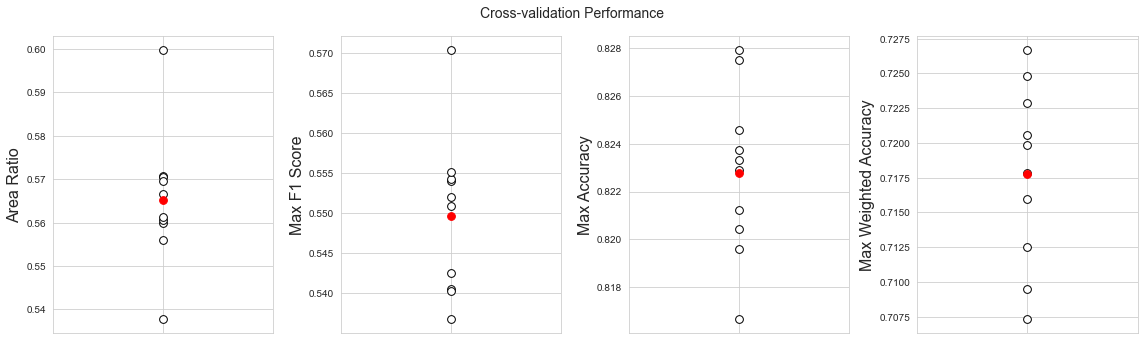

In [50]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))
fig.suptitle('Cross-validation Performance', fontsize=14)
fig.tight_layout()

## This figure will compare the area ratios
ax1.scatter(np.ones(10), 
                areas, 
                s=60, 
                c='white',
                edgecolor='black',
                label='Single Split')

ax1.scatter([1], np.mean(areas), s=60, c='r', label="Mean")

ax1.set_xticks([1], [" "])

ax1.set_ylabel("Area Ratio", fontsize=16)

## This figure will compare the f1 scores
ax2.scatter(np.ones(10), 
                f1_s, 
                s=60, 
                c='white',
                edgecolor='black',
                label='Single Split')

ax2.scatter([1], np.mean(f1_s), s=60, c='r', label="Mean")

ax2.set_xticks([1], [" "])

ax2.set_ylabel("Max F1 Score", fontsize=16)

## This figure will compare the accuracies
ax3.scatter(np.ones(10), 
                acc_s, 
                s=60, 
                c='white',
                edgecolor='black',
                label='Single Split')

ax3.scatter([1], np.mean(acc_s), s=60, c='r', label="Mean")

ax3.set_xticks([1], [" "])

ax3.set_ylabel("Max Accuracy", fontsize=16)

## This figure will compare the weighted accuracies
ax4.scatter(np.ones(10), 
                wacc_s, 
                s=60, 
                c='white',
                edgecolor='black',
                label='Single Split')

ax4.scatter([1], np.mean(wacc_s), s=60, c='r', label="Mean")

ax4.set_xticks([1], [" "])

ax4.set_ylabel("Max Weighted Accuracy", fontsize=16)

fig.tight_layout()
plt.show()

In [51]:
print("Mean area ratio across cross-validation:", np.round(np.mean(areas), 3))
print("Mean max-F1 across cross-validation:", np.round(np.mean(f1_s), 3))
print("Mean max-accuracy across cross-validation:", np.round(np.mean(acc_s), 3))
print("Mean max-wt-accuracy across cross-validation:", np.round(np.mean(wacc_s), 3))

Mean area ratio across cross-validation: 0.565
Mean max-F1 across cross-validation: 0.55
Mean max-accuracy across cross-validation: 0.823
Mean max-wt-accuracy across cross-validation: 0.718


It is the moment we have all been waiting for!  We will fit our random forest model on the training data.  Then we will make predictions both on the training data and on the testing data, to compare.  We keep track of all the same metrics and see how our model does.

In [40]:
pipe = RandomForestClassifier(n_estimators = 100, max_depth = 7, max_samples = 7000, random_state=36830)
pipe.fit(X, y)

X_test = preprocess(df_test).drop(columns=["default payment next month"])
y_test = df_test["default payment next month"]

predproba_train = pipe.predict_proba(X)[:,1]
predproba_test = pipe.predict_proba(X_test)[:,1]

area_train = area_ratio(y.values, predproba_train)
area_test = area_ratio(y_test.values, predproba_test)
cmat_list_train = conf_matrix_components(cutoffs, y.values, predproba_train)
cmat_list_test = conf_matrix_components(cutoffs, y_test.values, predproba_test)
f1_train = max(f1_scores(cmat_list_train))
f1_test = max(f1_scores(cmat_list_test))
acc_train = max(accuracy(cmat_list_train))
acc_test = max(accuracy(cmat_list_test))
wacc_train = max(weighted_accuracy(cmat_list_train))
wacc_test = max(weighted_accuracy(cmat_list_test))

In [41]:
print("Area ratio on training set:", np.round(area_train, 3), "\nArea ratio on testing set:", np.round(area_test, 3))
print("Max F1 score on training set:", np.round(f1_train, 3), "\nMax F1 score on testing set:", np.round(f1_test, 3))
print("Max accuracy on training set:", np.round(acc_train, 3), "\nMax accuracy on testing set:", np.round(acc_test, 3))
print("Max weighted accuracy on training set:", np.round(wacc_train, 3), "\nMax weighted accuracy on testing set:", np.round(wacc_test, 3))

Area ratio on training set: 0.612 
Area ratio on testing set: 0.556
Max F1 score on training set: 0.569 
Max F1 score on testing set: 0.545
Max accuracy on training set: 0.831 
Max accuracy on testing set: 0.818
Max weighted accuracy on training set: 0.731 
Max weighted accuracy on testing set: 0.715


It looks exactly as we might have expected: we get the best performance on the training set itself, then on cross-validation (where we did our tuning), and then slightly worse is the testing set.  But not very much worse!

The area ratio on the testing set is a ratio of areas in any of the three equivalent plots below.  We take the area between our curve and the "random guess" curve, and divide by the area between the "perfect guess" curve and the "random guess" curve.  Here are the three plots:
- The Receiver Operating Characteristic (ROC) curve has false positive rate on the horizontal axis, and true positive rate on the vertical axis.
- The Lift Chart (or Gains Curve) has the proportion of clients selected (as defaulters) on the horizontal axis, and the proportion of total clients selected correctly (as defaulters) on the vertical axis.  It differs from the ROC curve by a scaling of each axis, and a shearing transformation.
- The Detection Error Tradeoff (DET) curve has false positive rate on the horizontal axis, and false negative rate on the vertical axis.  Because the sum of true positive rate and false negative rate is 1, this curve differs from the ROC curve by reflection over a horizontal line.

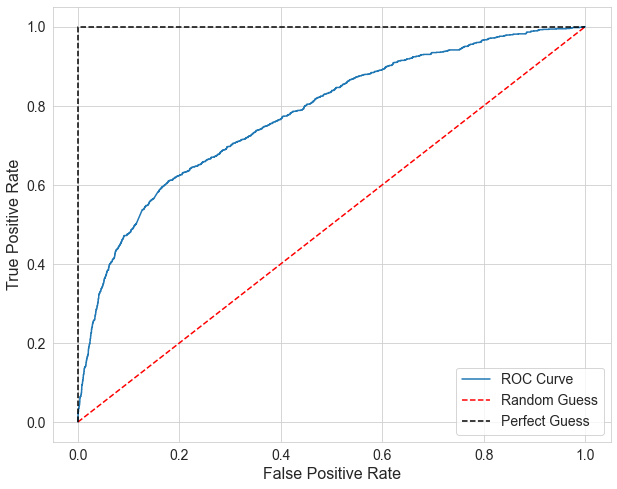

In [47]:
roc_chart(y_test.values, predproba_test)

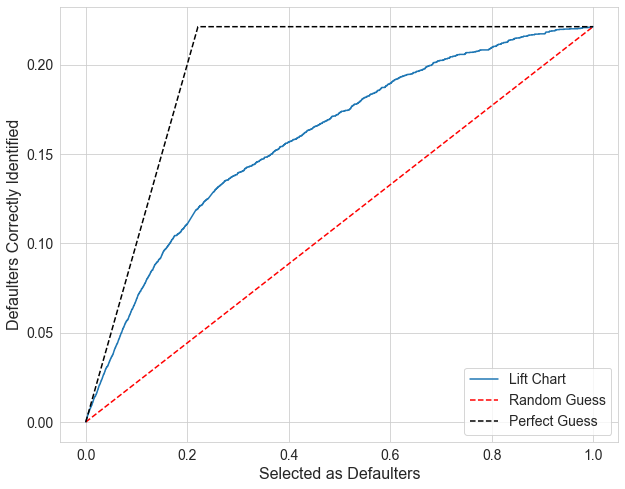

In [42]:
lift_chart(y_test.values, predproba_test)

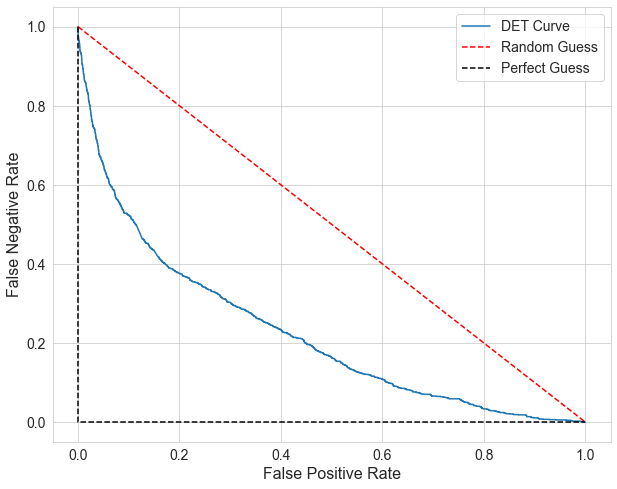

In [48]:
det_chart(y_test.values, predproba_test)